# Inverse transformations and test-time augmentations

This notebook demonstrates the use of invertible transforms. Later in the notebook, we also look at performing the inverse transformations as a post transform (for inferred segmentations), and then leveraging inverse transformations to perform test-time augmentations.


### What are transforms?

- We use transforms to modify data. In MONAI, we use them to (for example) load images from file, add a channel component, normalise the intensities and reshape the image.
- We can also use transforms as a method of data augmentation – we have a finite amount of data so to avoid overfitting, we can apply random transforms to modify our data each epoch.
- Examples of random transformations might be randomly flipping, rotating, cropping, padding, zooming, as well as applying non-rigid deformations.


### Inverse transforms

- Having applied transformations (random or not) to our data, it can often be useful to return them to their original space after. You might, for example, want to use a network to segment an image, and then you'll want that segmented image in the same space as the input so that you can compare them. You could then save them to file and compare them in your favourite medical image viewer.
- In MONAI, the majority of our spatial transforms are invertible. You can double check with `isinstance(x, InvertibleTransform)`.

### Test-time augmentations

- If your network includes random transformations, you may want to observe the effect that these transformations have on the output.
- To do this, you could pass the same input through the network multiple times, using different random realisations. You could then use the inverse transforms to move all the results to a common space, and you could then calculate the metrics.
- This is the purpose of MONAI's `TestTimeAugmentation`, which by default will calculate the mode, mean, standard deviation and volume variation coefficient. For more information on this, see https://doi.org/10.1016/j.neucom.2019.01.103.

### This notebook

For the sake of speed, we'll use a 2D dataset here, although the workflow would be identical for 3D data. We create simple circular data, please check [this MONAI tutorial](https://github.com/Project-MONAI/tutorials/blob/master/modules/inverse_transforms_and_test_time_augmentations.ipynb) for similar examples using Decathlon's 3D brain tumor dataset

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange

import monai
from monai.data import DataLoader, Dataset, TestTimeAugmentation, create_test_image_2d
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activationsd,
    AsDiscreted,
    Compose,
    CropForegroundd,
    DivisiblePadd,
    Invertd,
    LoadImaged,
    ScaleIntensityd,
    RandRotated,
    RandRotate,
    InvertibleTransform,
    RandFlipd,
    Activations,
    AsDiscrete,
)
from monai.utils import set_determinism

set_determinism(43)
monai.config.print_config()

MONAI version: 0.6.0
Numpy version: 1.21.2
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: 2.8.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.0
ITK version: 5.2.1
tqdm version: 4.61.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Create plotting function

In [3]:
def imshows(im_dict, colorbar=False):
    """Visualises a dictionary of data.

    The width of each subplot is set to
    correspond with the size of each image.
    """
    ncol = len(im_dict)
    grid = {"width_ratios": [i.shape[1] for i in im_dict.values()]}
    fig, axes = plt.subplots(1, ncol, figsize=(ncol * 3, 3),
                             facecolor='white', gridspec_kw=grid)
    for ax, (title, im) in zip(axes, im_dict.items()):
        im = im[0]  # remove channel
        if isinstance(im, torch.Tensor):
            im = im.detach().cpu().numpy()
        ax.set_title(f"{title}\n{im.shape}")
        im_show = ax.imshow(im)
        ax.axis("off")
        if colorbar:
            fig.colorbar(im_show, ax=ax)

# Create test image

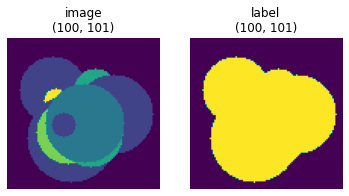

In [4]:
def get_data(width=100, height=101):
    image, _ = create_test_image_2d(width=100, height=101, channel_dim=0)
    label = (image > 0).astype(np.float32)
    data = {"image": image, "label": label}
    return data

imshows(get_data())

# Which transforms are invertible?

In the following cell, we check if some transforms are invertible or not.

In MONAI, information that will be required to perform the inverse is stored. Hence, only our dictionary-based transforms are invertible, as this information is stored in the dictionary. If a transform was applied to the key `image`, then `image_transform` will be used to store the information on that applied transform.

For this reason, `RandRotate`, being an array transform is not invertible, unlike `RandRotated`. 

In [5]:
keys = ["image", "label"]
t = RandRotated(keys)
print("RandRotated:", isinstance(t, InvertibleTransform))
t = RandRotate()
print("RandRotate:", isinstance(t, InvertibleTransform))

RandRotated: True
RandRotate: False


# Apply a transform

Here, we'll apply a transform and then inspect the resulting dictionary.

keys before: dict_keys(['image', 'label'])
keys after: dict_keys(['image', 'label', 'image_transforms', 'label_transforms'])
invertible transforms: [{'class': 'RandRotated', 'id': 140521785270608, 'orig_size': (100, 101), 'extra_info': {'rot_mat': array([[ -0.25737591,  -0.96631136, 124.14492352],
       [  0.96631136,  -0.25737591,   6.75493793],
       [  0.        ,   0.        ,   1.        ]]), 'mode': 'bilinear', 'padding_mode': 'border', 'align_corners': False}, 'do_transforms': True}]


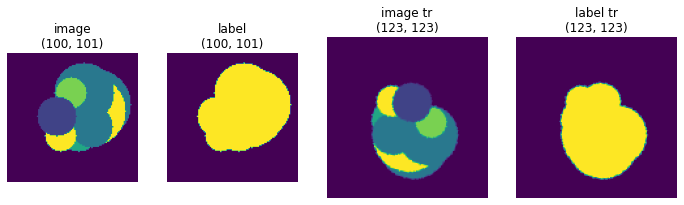

In [6]:
transform = RandRotated(keys, range_x=[1,2], prob=1, keep_size=False)
data = get_data()
data_tr = transform(data)
imshows({
    "image": data["image"],
    "label": data["label"],
    "image tr": data_tr["image"],
    "label tr": data_tr["label"],
})

print("keys before:", data.keys())
print("keys after:", data_tr.keys())
print("invertible transforms:", data_tr["image_transforms"])

# Apply multiple transforms

Note that when multiple transforms are called, they are stored in a list, with each element containing a dictionary of data corresponding to each applied transform.

transform 0
    class: RandRotated
    id: 140521741942864
    orig_size: (100, 101)
    extra_info: {'rot_mat': array([[  0.20447992,  -0.97887076,  95.18905963],
       [  0.97887076,   0.20447992, -19.81768995],
       [  0.        ,   0.        ,   1.        ]]), 'mode': 'bilinear', 'padding_mode': 'border', 'align_corners': False}
    do_transforms: True
transform 1
    class: CropForegroundd
    id: 140521741942928
    orig_size: (119, 119)
    extra_info: {'box_start': array([13, 16]), 'box_end': array([105,  94])}


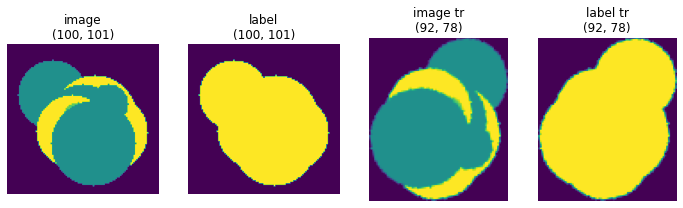

In [7]:
transform = Compose([
    RandRotated(keys, range_x=[1,2], prob=1, keep_size=False),
    CropForegroundd(keys, source_key="label"),
])
data = get_data()
data_tr = transform(data)
imshows({
    "image": data["image"],
    "label": data["label"],
    "image tr": data_tr["image"],
    "label tr": data_tr["label"],
})

for i, tr in enumerate(data_tr["image_transforms"]):
    print(f"transform {i}")
    for k, v in tr.items():
        print(f"    {k}: {v}")

# Apply the inverse!

All invertible transforms (`Compose` is also an invertible transform) have the `inverse` method. Simply call this to invert the data.

remaining invertible transforms: []


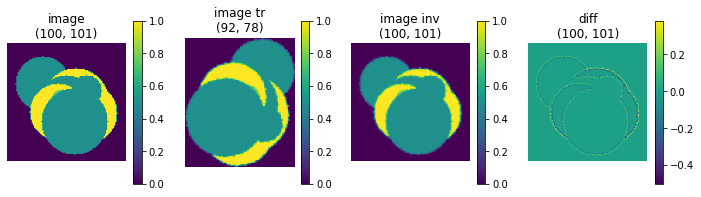

In [8]:
data_inv = transform.inverse(data_tr)
# list of transforms is now blank
print("remaining invertible transforms:", data_inv["image_transforms"])
imshows({
    "image": data["image"],
    "image tr": data_tr["image"],
    "image inv": data_inv["image"],
    "diff": data_inv["image"] - data["image"]
}, colorbar=True)

# Do some training

We'll do a really simple training to segment the image, creating a binary mask.

In [11]:
transform = Compose(
    [
        RandRotated(keys, range_x=[1,2], prob=1, keep_size=True),
        RandFlipd(keys, prob=0.5),
        ScaleIntensityd("image"),
        DivisiblePadd(keys, 16),
    ]
)

data = [get_data() for _ in range(100)]
train_ds = Dataset(data=data, transform=transform)
train_dl = DataLoader(train_ds, batch_size=10)

epoch 100, average loss: 0.0104: 100%|████████| 100/100 [00:18<00:00,  5.49it/s]


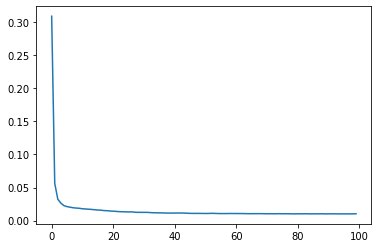

In [12]:
# Create network, loss fn., etc.
dice_metric = DiceMetric(include_background=True, reduction="mean")
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels=(2, 4),
    strides=(2, ),
).to(device)
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-1)

# start a typical PyTorch training
max_epochs = 100
epoch_losses = []
t = trange(max_epochs, desc=f"epoch 0, avg loss: inf", leave=True)
for epoch in t:
    epoch_loss = 0

    for batch in train_dl:
        inputs, labels = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_dl)
    epoch_losses.append(epoch_loss)
    t.set_description(f"epoch {epoch + 1}, average loss: {epoch_loss:.4f}")

plt.plot(epoch_losses)
_ = model.eval()

# Check segmentation

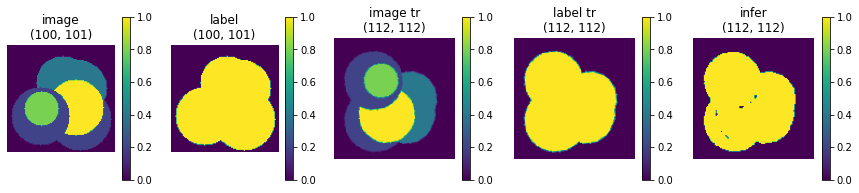

In [13]:
def infer(data, model, image_key="image", out_key="infer"):
    # infer
    image = torch.tensor(data[image_key]).to(device)[None]
    data[out_key] = model(image)[0].cpu().detach()

    post_trans = Compose([
        Activationsd(keys=out_key, sigmoid=True),
        AsDiscreted(keys=out_key, threshold_values=True),
    ])
    
    return post_trans(data)
    

data = get_data()
data_tr = transform(data)
data_tr = infer(data_tr, model)
imshows({
    "image": data["image"],
    "label": data["label"],
    "image tr": data_tr["image"],
    "label tr": data_tr["label"],
    "infer": data_tr["infer"],
}, colorbar=True)

# Inverse after segmentation

All we need to do now is add in the `Invertd` post transform. We supply a dictionary that contains the inferred segmentation as well as the input images. In this way, we have access to the transforms that were performed prior to the inference.

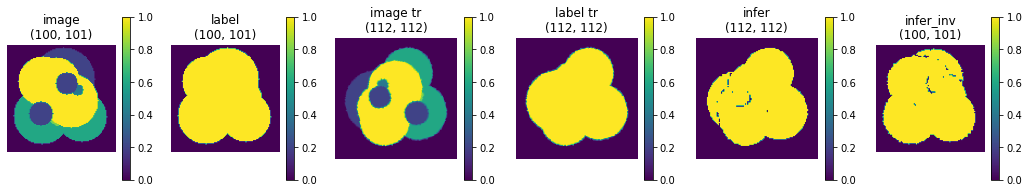

In [14]:
def infer(data, model, image_key="image", out_key="infer", invert=False):
    # infer
    image = torch.tensor(data[image_key]).to(device)[None]
    data[out_key] = model(image)[0].cpu().detach()

    post_trans = [
        Activationsd(keys=out_key, sigmoid=True),
        AsDiscreted(keys=out_key, threshold_values=True),
    ]
    if invert:
        post_trans.append(Invertd(out_key, transform, orig_keys=image_key))
    post_trans = Compose(post_trans)
    
    return post_trans(data)
    

data = get_data()
data_tr = transform(data)
data_tr = infer(data_tr, model, out_key="infer")
data_tr = infer(data_tr, model, out_key="infer_inv", invert=True)
imshows({
    "image": data["image"],
    "label": data["label"],
    "image tr": data_tr["image"],
    "label tr": data_tr["label"],
    "infer": data_tr["infer"],
    "infer_inv": data_tr["infer_inv"],
}, colorbar=True)

## Test-time augmentations

For the test-time augmentations, we need to tell it which transformations to apply (`transform`), as well as how to extract the output (infer the segmentations).

We then parameterise `num_examples`, and the network will be called this number of times, resulting in segmentations that are different due to differences caused by random transformations. The inverse is applied to each segmentation, and the results averaged.

The mode, mean, standard deviation and volume variation coefficient are returned.

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 57.51it/s]


Volume variation coefficient: 1.1075443029403687


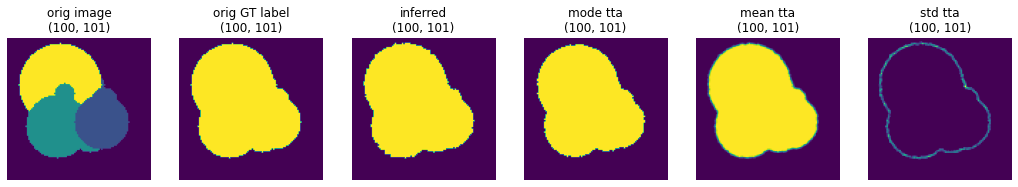

In [15]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(threshold_values=True),
])

def inferrer_fn(x):
    x = post_trans(model(x))
    return x

tt_aug = TestTimeAugmentation(
    transform,
    batch_size=5,
    num_workers=0,
    inferrer_fn=inferrer_fn,
    device=device
)

data = get_data()
mode_tta, mean_tta, std_tta, vvc_tta = tt_aug(data, num_examples=100)
data_tr = transform(data)
data_tr = infer(data_tr, model, out_key="infer", invert=True)

imshows({    
    "orig image": data["image"],
    "orig GT label": data["label"],
    "inferred": data_tr["infer"],
    "mode tta": mode_tta,
    "mean tta": mean_tta,
    "std tta": std_tta,
})
print("Volume variation coefficient:", vvc_tta)